<table>
    <tr><td> <b>Group</b> </td><td>BML36</td></tr>
    <tr><td> <b>Names</b> </td><td>Thibault Douzon</td></tr>
    <tr><td> <b></b> </td><td>Rajavarman Mathivanan</td></tr>
</table>

In [1]:
#%matplotlib inline
import numpy as np
import operator
import pylab
from matplotlib import pyplot as plt

pylab.rcParams['figure.figsize'] = (10.0, 8.0)


# Decision Trees

In this lab, we will implement the C4.5 algorithm for classification with decision trees. Please make sure that you read the complete description and code below.


## Data

Let's start by loading the datasets that we will be working with. The ```mushroom``` dataset is a dataset describing the features of different species of mushrooms, and the goal is to derive simple rules to predict whether a species is poisonous or not.

In [2]:
# This code is given
data = np.load("uci-mushrooms.npz")
# data = np.load("hiv.npz")
print(data.keys())

d = data['inputs']
l = data['targets']
fname = data['feature_names']
print(fname)
print(list(l).count(b'POISONOUS'))

KeysView(<numpy.lib.npyio.NpzFile object at 0x000002511B49A240>)
[b'cap-shape' b'cap-surface' b'cap-colour' b'bruises?' b'odour'
 b'gill-attachment' b'gill-spacing' b'gill-size' b'gill-colour'
 b'stalk-shape' b'stalk-root' b'stalk-surface-above-ring'
 b'stalk-surface-below-ring' b'stalk-colour-above-ring'
 b'stalk colour-below-ring' b'veil type' b'veil colour' b'Number-of-rings'
 b'Type-of-ring' b'spore-print-colour' b'population' b'habitat']
3928


## Helper functions

Here are a few functions to deal with categorical labels

In [3]:
# This code is given

def listValues(inputlist):
    """List the possible values of a given feature in a dataset"""
    values = set([])
    for x in inputlist:
        values.add(x)
    return list(values)

def countLabels(labelList):
    """Count how often each individual label is repeated in the list"""
    counts = {}
    for x in labelList:
        if x not in counts:
            counts[x] = 1
        else:
            counts[x] += 1
    return counts

def majorityLabel(labelList):
    """Return the most common label in a list"""    
    counts = countLabels(labelList)
#    print()"Majority label:", counts)
    return max(counts.items(), key=operator.itemgetter(1))[0]


print(listValues(l))
print(listValues(d[:,0]))
print(countLabels(l))
print(majorityLabel(d[:,1]))

[b'POISONOUS', b'EDIBLE']
[b'CONICAL', b'SUNKEN', b'CONVEX', b'FLAT', b'KNOBBED', b'BELL']
{b'POISONOUS': 3928, b'EDIBLE': 4488}
b'SCALY'


## Computing the entropy of a list of categorical values

The decision tree makes its decision based on decision nodes, and these nodes are evaluated based on information gain they provide on the training data. Information gain is computed as 
$$
IG = H(parent) - \sum_j \frac{N_j}{N} H(child=j)
$$
the entropy of the data associated with the parent, minus the weighted entropy of the data-subsets associated with the chidlren

**question 1 [5 credits]]** Implement a helper function that computes the entropy of a set of categorical labels


In [4]:
"""0.9968038285222955"""
# Answer to Question 1
#ANSQ1
def entropy(labelList):
    e = 0
    for label, count in countLabels(labelList).items():
        e -= count/len(labelList)*np.log2(count/len(labelList))
    return e
        
print(entropy(l))
               
# Comment: it is possible for the entropy to be larger than one, if you 
# consider distributions over more than 2 values. Don't panic :-)
#/ANSQ1

0.9968038285222955


## Implementing the tree

Below, you are given the code to make a decision tree, train it and classify datapoints using binary decision nodes based on categorical variables. 

The implementation creates ```Node``` objects, which provide three methods: ```classify```, which returns the predicted label for a datapoint, and ```entropy``` and ```informationGain```, which are used in training. How ```classify``` does its work depends on the type of node, and is implemented in the derived classes. 

```Leaf``` nodes return a fixed classification result that does not depend on the datapoint at all: the classification is defined by the path that was traveled through the tree to reach that node (and, of course, that path depends on the value of the datapoint). ```Leaf``` nodes simply return the majority label of the training data that is associated with them. All other nodes allow have children, and their ```classify``` method consists of deciding which child to select to classify the datapoint. A first implementation of such a node is the ```BinaryNode```, which makes a binary decision on which of its two children should be responsible for the further classification.

Each ```Node```'s constructor is given training data which is used to optimise the ```Node```'s classification strategy. ```Leaf``` nodes use this data to select the majority class, ```BinaryNodes``` select the most informative feature and that feature's most informative value in their data. When ```classify```ing a new datapoint, they select which child should perform the classification based on whether or not the corresponding feature of the datapoint equals that value, or not.

In [5]:
# This code is given

class Node:
    """Abstract class for a decision tree node"""
    def classify(self, datapoint):
        """Return the classification label for the given datapoint"""
        raise Exception("Not Implemented")        
    def entropy(self):
        """Return the entropy of the training data associated with this node"""
    def informationGain(self):
        """Return the information gain of this node on the training data """
        raise Exception("Not Implemented by derived class")

class Leaf(Node):
    """Leaf node, i.e., a node with no children"""
    def __init__(self,inputs, targets):
#        print "Inputs, targets:", inputs.shape, targets.shape
        
        self.v = majorityLabel(targets)
        self.inputs = inputs
        self.targets = targets
        self.children = None
        self.H = entropy(targets)
        
    def entropy(self):
        """Return the entropy of the training data associated with this node"""
        return self.H
    
    def informationGain(self):
        """No splitting of the data, so no information gain"""
        return 0.
    
    def classify(self,datapoint):
        #print(str(self), "I'm a Leaf")

        """Return the majority class for this node (and ignore the actual value of the datapoint)"""
        return self.v
    
    def __str__(self): 
        """Used for printing trees"""
        return "\t\t\t=> %s [Leaf]" % (self.v)
    
class BinaryNode(Node):
    """Make a decision based on whether a given feature equals a specific value, or not"""
    def __init__(self, inputs, targets, feature):
        self.feature = feature
        self.value   = None
        self.IG      = 0.0
        self.H       = entropy(targets)                     # Entropy of unsplit data
        self.inputs  = inputs
        self.targets = targets
        N = float(targets.size)                             # Total number of datapoints

        for value in listValues(inputs[:,feature]):         # Go through all possible values for the given feature
            indicesTrue  = inputs[:,feature]==value         # Split the training data based on that feature/value
            indicesFalse = inputs[:,feature]!=value

            if indicesTrue.all() or indicesFalse.all():     # If none (or all) datapoints have the same value for that feature                  
                continue                                    # ... keep going

            children = [ Leaf(inputs[indicesTrue,:], targets[indicesTrue]),    # Temporarily create children
                         Leaf(inputs[indicesFalse,:], targets[indicesFalse]) ] # based on this split
            conditions = [ "%s==%s" % (fname[feature], value), "%s!=%s" % (fname[feature], value) ] # (for printing)

            Nt = float(children[0].targets.size)        # N.o. datapoints in True condition
            Nf = float(children[1].targets.size)        # N.o. datapoints in False condition
            pt = Nt/N
            pf = Nf/N
            ig = self.H - pt * children[0].entropy() - pf * children[1].entropy() # Compute the information gain 
                                                        # with the temporary children
            if ig > self.IG:                            # Check whether that information gain was better than what we had
                self.value = value                      # and if so, update the node and make those children permanent 
                self.IG = ig
                self.children = children
                self.conditions = conditions
    
    def entropy(self):
        return self.H
    
    def informationGain(self):
        """Return the entropy gain of splitting the given data according to 
        the specified feature and value"""
        return self.IG
    
    def classify(self, x):
        #print(str(self), x[self.feature], "NOT A LEAF")

        if x[self.feature] == self.value:
            return self.children[0].classify(x)
        else:
            return self.children[1].classify(x)
        
    def __str__(self):
        return " => Binary decision: '%s =?= %s'" % (fname[self.feature], self.value )
    
    

In [13]:
# This code implements the C4.5 training algorithm for decision trees.
# It is given BUT MUST BE MODIFIED! (Question 2)

# Don't worry too much about the following line, it'll come in handy later when 
# we work with heterogeneous features 
allBinary = [ BinaryNode for i in range(d[0].size) ] # all features require Binary Nodes

def c45(inputs, targets, featureType = allBinary, minSize=0):
    """Implement the C4.5 training algorithm for a classification tree"""
    ig = 0.      # Initialise the information gain as 0
    res = None   # Keep track of the best feature so far
    for feature in range(inputs.shape[1]): # Cycle through all possible features
        n = featureType[feature](inputs,targets,feature) # Create a Node of the right type for that feature
        if n.informationGain() > ig: # If that node is better than what we'd found until now, 
            ig = n.informationGain() # keep that node
            res = n
    if not res: # IF no interesting feature was found for this data, return None
#        print "WARNING: No informative feature found" # Comment this out for more verbose output
        return res
    for i in range(len(res.children)): # Now go through the children of the best node we've created
        if res.children[i].entropy() > 0.: # If that child can still be split up
            c = c45(res.children[i].inputs, res.children[i].targets, featureType, minSize) # recursively try to split it up
            if c: # if splitting it up was successful (return value is not None)
                res.children[i]=c # update the child with the created subtree
    return res


root = c45(d,l)

b'POISONOUS' 3928
b'EDIBLE' 4488
b'POISONOUS' 1712
b'EDIBLE' 2084
b'POISONOUS' 2216
b'EDIBLE' 2404
b'POISONOUS' 4
b'POISONOUS' 3924
b'EDIBLE' 4488
b'POISONOUS' 604
b'EDIBLE' 236
b'POISONOUS' 3324
b'EDIBLE' 4252
b'EDIBLE' 32
b'POISONOUS' 3928
b'EDIBLE' 4456
b'POISONOUS' 48
b'EDIBLE' 404
b'POISONOUS' 3880
b'EDIBLE' 4084
b'POISONOUS' 1560
b'EDIBLE' 1732
b'POISONOUS' 2368
b'EDIBLE' 2756
b'POISONOUS' 3928
b'EDIBLE' 4488
b'POISONOUS' 4
b'POISONOUS' 3924
b'EDIBLE' 4488
b'POISONOUS' 760
b'EDIBLE' 1700
b'POISONOUS' 3168
b'EDIBLE' 2788
b'POISONOUS' 1412
b'EDIBLE' 1272
b'POISONOUS' 2516
b'EDIBLE' 3216
b'POISONOUS' 1752
b'EDIBLE' 1516
b'POISONOUS' 2176
b'EDIBLE' 2972
b'POISONOUS' 3928
b'EDIBLE' 4488
b'POISONOUS' 120
b'EDIBLE' 48
b'POISONOUS' 3808
b'EDIBLE' 4440
b'POISONOUS' 12
b'EDIBLE' 32
b'POISONOUS' 3916
b'EDIBLE' 4456
b'POISONOUS' 320
b'EDIBLE' 720
b'POISONOUS' 3608
b'EDIBLE' 3768
b'POISONOUS' 88
b'EDIBLE' 56
b'POISONOUS' 3840
b'EDIBLE' 4432
b'POISONOUS' 876
b'EDIBLE' 624
b'POISONOUS' 3052
b'E

b'POISONOUS' 120
b'EDIBLE' 3544
b'EDIBLE' 596
b'POISONOUS' 120
b'EDIBLE' 3092
b'POISONOUS' 80
b'EDIBLE' 2932
b'POISONOUS' 40
b'EDIBLE' 756
b'POISONOUS' 40
b'EDIBLE' 16
b'POISONOUS' 80
b'EDIBLE' 3672
b'POISONOUS' 120
b'EDIBLE' 3688
b'EDIBLE' 192
b'POISONOUS' 120
b'EDIBLE' 3496
b'EDIBLE' 576
b'POISONOUS' 120
b'EDIBLE' 3112
b'POISONOUS' 112
b'EDIBLE' 2232
b'POISONOUS' 8
b'EDIBLE' 1456
b'EDIBLE' 96
b'POISONOUS' 120
b'EDIBLE' 3592
b'EDIBLE' 576
b'POISONOUS' 120
b'EDIBLE' 3112
b'POISONOUS' 8
b'POISONOUS' 112
b'EDIBLE' 3688
b'EDIBLE' 16
b'POISONOUS' 120
b'EDIBLE' 3672
b'POISONOUS' 120
b'EDIBLE' 3688
b'EDIBLE' 192
b'POISONOUS' 120
b'EDIBLE' 3496
b'EDIBLE' 576
b'POISONOUS' 120
b'EDIBLE' 3112
b'POISONOUS' 80
b'EDIBLE' 2160
b'POISONOUS' 40
b'EDIBLE' 1528
b'EDIBLE' 96
b'POISONOUS' 120
b'EDIBLE' 3592
b'EDIBLE' 576
b'POISONOUS' 120
b'EDIBLE' 3112
b'POISONOUS' 24
b'POISONOUS' 96
b'EDIBLE' 3688
b'POISONOUS' 16
b'EDIBLE' 88
b'POISONOUS' 104
b'EDIBLE' 3600
b'POISONOUS' 120
b'EDIBLE' 3688
b'POISONOUS' 12

b'POISONOUS' 8
b'EDIBLE' 3552
b'EDIBLE' 268
b'POISONOUS' 8
b'EDIBLE' 3404
b'EDIBLE' 64
b'POISONOUS' 8
b'EDIBLE' 3608
b'EDIBLE' 776
b'POISONOUS' 8
b'EDIBLE' 2896
b'POISONOUS' 8
b'EDIBLE' 3672
b'EDIBLE' 2752
b'POISONOUS' 8
b'EDIBLE' 920
b'POISONOUS' 8
b'EDIBLE' 920
b'EDIBLE' 2752
b'POISONOUS' 8
b'EDIBLE' 3672
b'EDIBLE' 720
b'POISONOUS' 8
b'EDIBLE' 2952
b'POISONOUS' 8
b'EDIBLE' 1832
b'EDIBLE' 1840
b'EDIBLE' 1120
b'POISONOUS' 8
b'EDIBLE' 2552
b'POISONOUS' 8
b'EDIBLE' 3672
b'EDIBLE' 144
b'POISONOUS' 8
b'EDIBLE' 3528
b'EDIBLE' 548
b'POISONOUS' 8
b'EDIBLE' 3124
b'POISONOUS' 8
b'EDIBLE' 2980
b'EDIBLE' 692
b'POISONOUS' 8
b'EDIBLE' 3672
b'EDIBLE' 144
b'POISONOUS' 8
b'EDIBLE' 3528
b'EDIBLE' 596
b'POISONOUS' 8
b'EDIBLE' 3076
b'POISONOUS' 8
b'EDIBLE' 2932
b'EDIBLE' 740
b'POISONOUS' 8
b'EDIBLE' 3672
b'POISONOUS' 8
b'EDIBLE' 2232
b'EDIBLE' 1440
b'EDIBLE' 192
b'POISONOUS' 8
b'EDIBLE' 3480
b'EDIBLE' 576
b'POISONOUS' 8
b'EDIBLE' 3096
b'EDIBLE' 96
b'POISONOUS' 8
b'EDIBLE' 3576
b'EDIBLE' 576
b'POISONOUS' 

b'POISONOUS' 3552
b'EDIBLE' 800
b'POISONOUS' 3808
b'EDIBLE' 800
b'POISONOUS' 2208
b'POISONOUS' 1600
b'EDIBLE' 800
b'POISONOUS' 144
b'POISONOUS' 3664
b'EDIBLE' 800
b'POISONOUS' 1456
b'EDIBLE' 800
b'POISONOUS' 2352
b'POISONOUS' 3808
b'EDIBLE' 800
b'POISONOUS' 2160
b'POISONOUS' 1648
b'EDIBLE' 800
b'POISONOUS' 144
b'POISONOUS' 3664
b'EDIBLE' 800
b'POISONOUS' 1456
b'EDIBLE' 608
b'POISONOUS' 2352
b'EDIBLE' 192
b'POISONOUS' 48
b'EDIBLE' 192
b'POISONOUS' 3760
b'EDIBLE' 608
b'POISONOUS' 3808
b'EDIBLE' 800
b'POISONOUS' 1600
b'EDIBLE' 800
b'POISONOUS' 2208
b'POISONOUS' 48
b'POISONOUS' 3760
b'EDIBLE' 800
b'POISONOUS' 432
b'POISONOUS' 3376
b'EDIBLE' 800
b'POISONOUS' 432
b'POISONOUS' 3376
b'EDIBLE' 800
b'POISONOUS' 1296
b'POISONOUS' 2512
b'EDIBLE' 800
b'POISONOUS' 3808
b'EDIBLE' 800
b'POISONOUS' 1600
b'EDIBLE' 800
b'POISONOUS' 2208
b'POISONOUS' 48
b'POISONOUS' 3760
b'EDIBLE' 800
b'POISONOUS' 432
b'POISONOUS' 3376
b'EDIBLE' 800
b'POISONOUS' 432
b'POISONOUS' 3376
b'EDIBLE' 800
b'POISONOUS' 1296
b'POIS

In [6]:
"""
+->   => Binary decision: 'b'odour' =?= b'NONE''
   +-> b'odour'==b'NONE'  => Binary decision: 'b'spore-print-colour' =?= b'GREEN''
   |  +-> b'spore-print-colour'==b'GREEN' 			=> b'POISONOUS' [Leaf]
   |  +-> b'spore-print-colour'!=b'GREEN'  => Binary decision: 'b'stalk-surface-below-ring' =?= b'SCALY''
   |     +-> b'stalk-surface-below-ring'==b'SCALY'  => Binary decision: 'b'gill-size' =?= b'BROAD''
   |     |  +-> b'gill-size'==b'BROAD' 			=> b'EDIBLE' [Leaf]
   |     |  +-> b'gill-size'!=b'BROAD' 			=> b'POISONOUS' [Leaf]
   |     +-> b'stalk-surface-below-ring'!=b'SCALY'  => Binary decision: 'b'cap-surface' =?= b'GROOVES''
   |        +-> b'cap-surface'==b'GROOVES' 			=> b'POISONOUS' [Leaf]
   |        +-> b'cap-surface'!=b'GROOVES'  => Binary decision: 'b'gill-size' =?= b'BROAD''
   |           +-> b'gill-size'==b'BROAD' 			=> b'EDIBLE' [Leaf]
   |           +-> b'gill-size'!=b'BROAD'  => Binary decision: 'b'bruises?' =?= b'BRUISES''
   |              +-> b'bruises?'==b'BRUISES' 			=> b'POISONOUS' [Leaf]
   |              +-> b'bruises?'!=b'BRUISES' 			=> b'EDIBLE' [Leaf]
   +-> b'odour'!=b'NONE'  => Binary decision: 'b'bruises?' =?= b'BRUISES''
      +-> b'bruises?'==b'BRUISES'  => Binary decision: 'b'stalk-root' =?= b'CLUB''
      |  +-> b'stalk-root'==b'CLUB' 			=> b'EDIBLE' [Leaf]
      |  +-> b'stalk-root'!=b'CLUB'  => Binary decision: 'b'stalk-root' =?= b'ROOTED''
      |     +-> b'stalk-root'==b'ROOTED' 			=> b'EDIBLE' [Leaf]
      |     +-> b'stalk-root'!=b'ROOTED'  => Binary decision: 'b'gill-spacing' =?= b'CLOSE''
      |        +-> b'gill-spacing'==b'CLOSE' 			=> b'POISONOUS' [Leaf]
      |        +-> b'gill-spacing'!=b'CLOSE' 			=> b'EDIBLE' [Leaf]
      +-> b'bruises?'!=b'BRUISES' 			=> b'POISONOUS' [Leaf]
"""

# This code is given

def prettyPrint(tree, cond="", dlist = [True]):
    indent = ""
    for d in dlist[:-1]:
        indent += "   " if d else "|  "
    print(indent + "+-> " + cond + " " + tree.__str__())
    if tree.children:
        for cond,cld in zip(tree.conditions[:-1],tree.children[:-1]):
            prettyPrint(cld,cond,dlist + [ False ])
        prettyPrint(tree.children[-1], tree.conditions[-1], dlist+[ True ])

    

#prettyPrint(root)


# Training 

The code above trains a decision tree.

**Question 2 [5 credits]** Modify the training function provided above to stop splitting nodes when the corresponding training data contains less than ```minSize``` datapoints, where ```minSize``` is a parameter to the function. Split the data into 80\% train and 20\% test, and use 5-fold cross-validation on the training set to find a good value for this parameter (You can use external libraries to split up the data if that's easier). Then report the confusion matrix, precision, recall and accuracy that you obtain on the test set.


Doing size 0
0.9763355201499532 1.0 0.8870246085011185
0.9772780510658233 1.0 0.8883774453394706
0.977512297962052 1.0 0.8896551724137931
0.9758725696884516 1.0 0.8829545454545454
0.9772780510658233 1.0 0.8891428571428571
Doing size 10
0.9058106841611996 0.8262599469496021 0.6968680089485458
0.9123916608104943 0.8404401650618982 0.7031070195627158
0.9112204263293512 0.8042131350681536 0.7459770114942529
0.9055985008198641 0.8184245660881175 0.696590909090909
0.9055985008198641 0.8138297872340425 0.6994285714285714
[-0.00982456 -0.00865629]
Size selected is 10
  |	1  	|	-1
1 |	53 	|	207
-1|	210	|	784
Accuracy: 0.6674641148325359
Precision: 0.20384615384615384
Recall: 0.20152091254752852
It's very hard to select a good measure because the dataset is about 80% '1' and 20% '0'. Thus an easy way
to get 80% accuracy is to always predict '0'.
We don't know what the data refers to, even if we could assume it is related to medecine based on its name. Thus we don't know what is the most importan

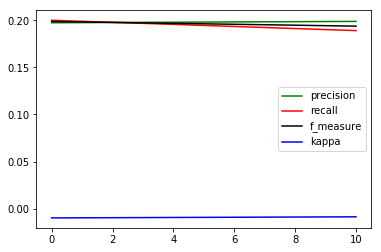

In [7]:
# Answer to Q2
#ANSQ2
import random
import sklearn.model_selection as skms


data = np.load("hiv.npz")
d = data["inputs"]
l = data["targets"]
fname = [ "feature-%d" % x for x in range(d.shape[1]) ]


allBinary = [ BinaryNode for i in range(d[0].size) ] # all features require Binary Nodes

def c45(inputs, targets, featureType = allBinary, minSize=0):
    #Copy-paste the previous code for c45 here, and modify it.
    """Implement the C4.5 training algorithm for a classification tree"""
    ig = 0.      # Initialise the information gain as 0
    res = None   # Keep track of the best feature so far
    for feature in range(inputs.shape[1]): # Cycle through all possible features
        n = featureType[feature](inputs,targets,feature) # Create a Node of the right type for that feature
        if n.informationGain() > ig: # If that node is better than what we'd found until now, 
            ig = n.informationGain() # keep that node
            res = n
    if not res: # IF no interesting feature was found for this data, return None
#        print "WARNING: No informative feature found" # Comment this out for more verbose output
        return res
    for i in range(len(res.children)): # Now go through the children of the best node we've created
        if res.children[i].entropy() > 0. and res.children[i].targets.size >= minSize: # If that child can still be split up
            c = c45(res.children[i].inputs, res.children[i].targets, featureType, minSize) # recursively try to split it up
            if c: # if splitting it up was successful (return value is not None)
                res.children[i]=c # update the child with the created subtree
    return res

# Function that divide data and labels in 2 sets, that approximately follow prop proportion
def divide_set(data, labels, prop):
    # 0 ≤ prop ≤ 1 is the proportion of items in the training set
    d_training = []
    l_training = []

    d_testing = []
    l_testing = []
    for x,c in zip(data, labels):
        # random number
        rnd = random.random()
        if rnd < prop:
            d_training += [x]
            l_training += [c]
        else:
            d_testing += [x]
            l_testing += [c]
            
    return np.array(d_training), np.array(l_training), np.array(d_testing), np.array(l_testing)

def conf_matrix(rel, ret):
    TP = sum([1 if x==b'1' and y==b'1' else 0 for x, y in zip(ret, rel)])
    TN = sum([1 if x==b'-1' and y==b'-1' else 0 for x, y in zip(ret, rel)])
    FP = sum([1 if x==b'1' and y==b'-1' else 0 for x, y in zip(ret, rel)])
    FN = sum([1 if x==b'-1' and y==b'1' else 0 for x, y in zip(ret, rel)])

    if TP+TN+FP+FN == 0: accuracy=0
    else: accuracy = (TP+TN)/(TP+TN+FP+FN) 
    if TP+FP==0: precision=0
    else: precision = (TP)/(TP+FP)
    if TP+FN==0: recall=0
    else: recall = (TP)/(TP+FN)
    return accuracy, precision, recall, (TP, FN, FP, TN)

# prettyPrint(root)

# Shuffle data and labels
z = list(zip(d, l))
random.shuffle(z)
d, l = zip(*z)
d, l = np.array(d), np.array(l)

# Split in train & test with proportion of 0.8
d_train, l_train, d_test, l_test = divide_set(d, l, 0.8)

KCV = skms.KFold(5)

min_size_l = list(range(0, 101, 10))
acc_ll = [[] for _ in min_size_l]
prec_ll = [[] for _ in min_size_l]
recall_ll = [[] for _ in min_size_l]
kappa_ll = [[] for _ in min_size_l]

for i,min_size in enumerate(min_size_l):
    print("Doing size {}".format(min_size))
    # For each split in KCV:
    for (i_train, i_validate) in KCV.split(d_train):
        # train on training data
        root = c45(d_train[i_train, :],l_train[i_train], minSize=min_size)
        
        prediction = [root.classify(x) for x in d_train[i_train]]
        actual = [x for x in l_train[i_train]] 
        accuracy, precision, recall, (TP, FN, FP, TN) = conf_matrix(actual, prediction)
        print(accuracy, precision, recall)
        
        # query on validate data
        prediction = [root.classify(x) for x in d_train[i_validate]]
        actual = [x for x in l_train[i_validate]]        
        
        accuracy, precision, recall, (TP, FN, FP, TN) = conf_matrix(actual, prediction)
        
        acc_ll[i] += [accuracy]
        prec_ll[i] += [precision]
        recall_ll[i] += [recall]
        
        # kappa from this https://en.wikipedia.org/wiki/Cohen%27s_kappa
        tot = TN+FN+TP+FP
        po = accuracy
        pe = (TP+FN)/tot*(TP+FP)/tot + (TN+FN)/tot*(TN+FP)/tot
        kappa_ll[i] += [(po-pe)/(1-pe)]

acc_ll = np.array(acc_ll)
prec_ll = np.array(prec_ll)
recall_ll = np.array(recall_ll)

acc_mean_l = [np.array(acc_ll[i]).mean() for i in range(len(min_size_l))]
prec_mean_l = [np.array(prec_ll[i]).mean() for i in range(len(min_size_l))]
recall_mean_l = [np.array(recall_ll[i]).mean() for i in range(len(min_size_l))]
kappa_mean_l = np.array([np.array(kappa_ll[i]).mean() for i in range(len(min_size_l))])
f_measure_l = np.array([2*p*r/(p+r) for p, r in zip(prec_mean_l, recall_mean_l)])

print(kappa_mean_l)

#plt.plot(min_size_l, acc_mean_l, 'b')
plt.plot(min_size_l, prec_mean_l, 'g')
plt.plot(min_size_l, recall_mean_l, 'r')
plt.plot(min_size_l, f_measure_l, 'k')
plt.plot(min_size_l, kappa_mean_l, 'b')
plt.legend(['precision', 'recall', 'f_measure', 'kappa'])

# Selecting the best min_size according to the precision:
min_size_l = np.array(min_size_l)

min_size = list(reversed(min_size_l))[list(reversed(kappa_mean_l.tolist())).index(max(kappa_mean_l))]

print('Size selected is {}'.format(min_size))

root = c45(d_train, l_train, minSize=min_size)

prediction = [root.classify(x) for x in d_test]
actual = [x for x in l_test]

accuracy, precision, recall,  (TP, FN, FP, TN) = conf_matrix(actual, prediction)

print("  |\t1  \t|\t-1")
print("1 |\t{} \t|\t{}".format(TP, FP))
print("-1|\t{}\t|\t{}".format(FN, TN))

print('Accuracy: {}\nPrecision: {}\nRecall: {}'.format(accuracy, precision, recall))

print("""It's very hard to select a good measure because the dataset is about 80% '1' and 20% '0'. Thus an easy way
to get 80% accuracy is to always predict '0'.
We don't know what the data refers to, even if we could assume it is related to medecine based on its name. Thus we don't know what is the most important to optimize (precision or recall)
Then we will chose the minSize parameter that maximize the kappa measure which tries to reflect the best tradeoff between precision and recall.
We could have used the f_measure but it does not take into account the quantity of TN, which in our case is most of the results. That's why we work with the kappa measure.
We tried with wider ranges of values for minSize up to 1000, but after 100, the resulting model starts to only predict '0'
and the recall drops very quickly.

Moreover, we can see that even with minSize of 0, the accuracy of our model on the training set is not 1. It's because it exists
multiple datapoints """)
#ANSQ2

### Continuous values

Until now, we have only dealt with categorical features. In the next part of the lab, you will deal with mixed categorical and continuous features.

One way to deal with continuous features is to split the dataset based on whether the feature is larger than a certain threshold, or not. The number of possible threshold values to consider is, of course, infinite in theory, but when deciding what the threshold value should be, based on a training dataset, only threshold values that will result in a different classification of those training examples matter: those are values that are smaller than one datapoint's feature value and larger than another's. Moreover, when considering a threshold in between two feature values, any value of the threshold in that range will result in the same classification, but to maximise generalisation it makes sense to maximise the margin: that is, to take a threshold value that is in the middle between the two.

Also note that it only makes sense to consider ranges of feature values that are disjoint, i.e., consider thresholds that are in the middle between neighbouring datapoints (along that feature's dimension), not in the middle between any pair of datapoints.

**Question 3 [10 credits]**. You guessed it, implement a node ```ContNode``` that selects a threshold value based on its training subset and classifies new datapoints based on whether they are smaller than that value, or not.

In [9]:

# This code must be modified.
#ANSQ3
def list_splits(input):
    value_l = sorted(input)
    
    # We do not include threshold that won't split the data in 2 non empty sets
    # because these splits won't iprove our classification.
    # Thus we do not include the first threshold before the first value
    # split_l = [value_l[0] - 0.5*abs(value_[0])]
    split_l = []
    for i, x in enumerate(value_l[:-1]):
        new_split = (x+value_l[i+1])/2
        if new_split not in split_l:
            split_l += [new_split]
            
    # We neither include the last threshold after the last value
    # split_l += [value_l[-1] + 0.5*abs(value_[-1])]
    return split_l


class ContNode(Node):
    """Make a binary decision based on a threshold, for the value of the given feature"""
    def __init__(self, inputs, targets, feature):
        self.feature = feature
        self.IG      = 0.0
        self.H       = entropy(targets)                     # Entropy of unsplit data
        self.inputs  = inputs
        self.targets = targets

        N = float(targets.size)                             # Total number of datapoints

        for split in list_splits(inputs[:,feature]):         # Go through all possible values for the given feature
            indicesTrue  = inputs[:,feature]>=split         # Split the training data based on that feature/value
            indicesFalse = inputs[:,feature]<split

            if indicesTrue.all() or indicesFalse.all():     # If none (or all) datapoints have the same value for that feature                  
                continue                                    # ... keep going

            children = [ Leaf(inputs[indicesTrue,:], targets[indicesTrue]),    # Temporarily create children
                         Leaf(inputs[indicesFalse,:], targets[indicesFalse]) ] # based on this split
            conditions = [ "%s<=%s" % (fname[feature], split), "%s>%s" % (fname[feature], split) ] # (for printing)

            Nt = float(children[0].targets.size)        # N.o. datapoints in True condition
            Nf = float(children[1].targets.size)        # N.o. datapoints in False condition
            pt = Nt/N
            pf = Nf/N
            ig = self.H - pt * children[0].entropy() - pf * children[1].entropy() # Compute the information gain 
                                                        # with the temporary children
            if ig > self.IG:                            # Check whether that information gain was better than what we had
                self.value = split                      # and if so, update the node and make those children permanent 
                self.IG = ig
                self.children = children
                self.conditions = conditions
        
        # Your code must fill in self.value here
        
    def entropy(self):
        return self.H
    
    def informationGain(self):
        """Return the entropy gain of splitting the given data according to 
        the specified feature and value"""
        return self.IG
    
    def classify(self, x):
        #print(str(self), x[self.feature], "NOT A LEAF")
        if x[self.feature] >= self.value:
            return self.children[0].classify(x)
        else:
            return self.children[1].classify(x)
        
    def __str__(self):
        return "=> threshold decision: %s >= %f" % (fname[self.feature],self.value)
#/ANSQ3

## Classification based on mixed features

The following dataset contains 14 features describing people's situation, and the classification task is to predict whether they earn more than \$50k a year or not. The categorical decision nodes we implemented above can work with any representation of categorical data, but the continuous decision node requires a numerical representation of the feature. Numpy arrays cannot easily contain both strings and numbers, and so to simplify our life, we converted the dataset to all numeric inputs and string targets.

To allow our classifier to work with mixed features, we use a numerical representation of the categorical features in the following. So, let's first load the data:

In [10]:
# This code is given

income = np.load('income.npz')
print(income.keys())
inputs = income['inputs']
targets = income['targets']
fname = income['fnames']
ftypes = income['ftypes']

print(ftypes)
print(targets.tolist().count(b'>50K'))
print(fname)

KeysView(<numpy.lib.npyio.NpzFile object at 0x000002511D601470>)
[b'continuous' b'categorical' b'continuous' b'categorical' b'continuous'
 b'categorical' b'categorical' b'categorical' b'categorical'
 b'categorical' b'continuous' b'continuous' b'continuous' b'categorical']
7841
[b'age' b'workclass' b'fnlwgt' b'education' b'education-num'
 b'marital-status' b'occupation' b'relationship' b'race' b'sex'
 b'capital-gain' b'capital-loss' b'hours-per-week' b'native-country']


**Question 4 [10 credits]** Take 1000 training datapoints at random from the dataset, and another 1000 test points that are distinct from those (don't mix train and test). Train a decision tree on the train set and report the confusion matrix obtained on the test set. What are the obtained precision, recall and accuracy? 

Doing size 0
1.0 1.0 1.0
1.0 1.0 1.0
1.0 1.0 1.0
1.0 1.0 1.0
1.0 1.0 1.0
Doing size 20
0.92625 0.927536231884058 0.976271186440678
0.925 0.9255813953488372 0.9802955665024631
0.91875 0.9365609348914858 0.9540816326530612
0.93625 0.9538714991762768 0.9617940199335548
0.93125 0.9368932038834952 0.973109243697479
Doing size 40
0.88875 0.9252971137521222 0.923728813559322
0.90125 0.9288025889967637 0.9425287356321839
0.88625 0.9382716049382716 0.9047619047619048
0.89625 0.9048361934477379 0.9634551495016611
0.91375 0.9214743589743589 0.9663865546218487
Doing size 60
0.88125 0.9159663865546218 0.923728813559322
0.8925 0.9322314049586777 0.9261083743842364
0.875 0.8948220064724919 0.9404761904761905
0.88 0.891640866873065 0.9568106312292359
0.90375 0.9163987138263665 0.957983193277311
Doing size 80
0.8675 0.8841269841269841 0.9440677966101695
0.88375 0.8981481481481481 0.9556650246305419
0.86875 0.8864 0.9421768707482994
0.8725 0.8834355828220859 0.9568106312292359
0.885 0.8911353032659409 0

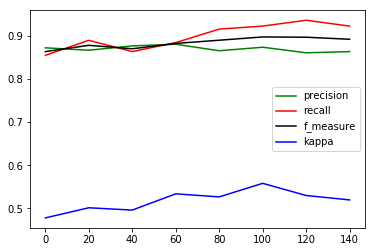

In [13]:
# Answer to Q4
"""Why only 1000 in each set ?"""
#ANSQ4
income = np.load('income.npz')
#print(income.keys())
inputs = income['inputs']
targets = income['targets']
fname = income['fnames']
ftypes = income['ftypes']


def c45(inputs, targets, featureType = allBinary, minSize=0):
    #Copy-paste the previous code for c45 here, and modify it.
    """Implement the C4.5 training algorithm for a classification tree"""
    ig = 0.      # Initialise the information gain as 0
    res = None   # Keep track of the best feature so far
    for feature in range(inputs.shape[1]): # Cycle through all possible features

        n = featureType[feature](inputs,targets,feature) # Create a Node of the right type for that feature
        if n.informationGain() > ig: # If that node is better than what we'd found until now, 
            ig = n.informationGain() # keep that node
            res = n
    if not res: # IF no interesting feature was found for this data, return None
        print("WARNING: No informative feature found") # Comment this out for more verbose output
        return res
    for i in range(len(res.children)): # Now go through the children of the best node we've created
        if res.children[i].entropy() > 0. and res.children[i].targets.size >= minSize: # If that child can still be split up
            c = c45(res.children[i].inputs, res.children[i].targets, featureType, minSize) # recursively try to split it up
            if c: # if splitting it up was successful (return value is not None)
                res.children[i]=c # update the child with the created subtree
    return res

def shuffle(data, labels):
    z = list(zip(data, labels))
    random.shuffle(z)
    d, l = zip(*z)
    return np.array(d), np.array(l)

def conf_matrix_income(rel, ret):
    TP = sum([1 if x==b'<=50K' and y==b'<=50K' else 0 for x, y in zip(ret, rel)])
    TN = sum([1 if x==b'>50K' and y==b'>50K' else 0 for x, y in zip(ret, rel)])
    FP = sum([1 if x==b'<=50K' and y==b'>50K' else 0 for x, y in zip(ret, rel)])
    FN = sum([1 if x==b'>50K' and y==b'<=50K' else 0 for x, y in zip(ret, rel)])

    if TP+TN+FP+FN == 0: accuracy=0
    else: accuracy = (TP+TN)/(TP+TN+FP+FN) 
    if TP+FP==0: precision=0
    else: precision = (TP)/(TP+FP)
    if TP+FN==0: recall=0
    else: recall = (TP)/(TP+FN)
    return accuracy, precision, recall, (TP, FN, FP, TN)

inputs, targets = shuffle(inputs, targets)

i_train, t_train, i_test, t_test = inputs[:1000], targets[:1000], inputs[1000:2000], targets[1000:2000]



node_type = [BinaryNode if t==b'categorical' else ContNode for t in ftypes]
# -------------------------------------------------

# The data is different, we make again some kcv to determine the best minSize.
# We use different data for train / test / kcv.
i_kcv, t_kcv = inputs[2000:3000], targets[2000:3000]
KCV = skms.KFold(5)

min_size_l = list(range(0, 141, 20))
acc_ll = [[] for _ in min_size_l]
prec_ll = [[] for _ in min_size_l]
recall_ll = [[] for _ in min_size_l]
kappa_ll = [[] for _ in min_size_l]

for i,min_size in enumerate(min_size_l):
    print("Doing size {}".format(min_size))
    # For each split in KCV:
    for (index_t, index_v) in KCV.split(i_kcv):
        # train on training data
        root = c45(i_kcv[index_t, :],t_kcv[index_t], featureType=node_type, minSize=min_size)

        prediction = [root.classify(x) for x in i_kcv[index_t]]
        actual = [x for x in t_kcv[index_t]] 
        accuracy, precision, recall, (TP, FN, FP, TN) = conf_matrix_income(actual, prediction)
        print(accuracy, precision, recall)
        
        # query on validate data
        prediction = [root.classify(x) for x in i_kcv[index_v]]
        actual = [x for x in t_kcv[index_v]]        
        
        accuracy, precision, recall, (TP, FN, FP, TN) = conf_matrix_income(actual, prediction)
        
        acc_ll[i] += [accuracy]
        prec_ll[i] += [precision]
        recall_ll[i] += [recall]
        
        # kappa from this https://en.wikipedia.org/wiki/Cohen%27s_kappa
        tot = TN+FN+TP+FP
        po = accuracy
        pe = (TP+FN)/tot*(TP+FP)/tot + (TN+FN)/tot*(TN+FP)/tot
        kappa_ll[i] += [(po-pe)/(1-pe)]


acc_ll = np.array(acc_ll)
prec_ll = np.array(prec_ll)
recall_ll = np.array(recall_ll)

# Compute the means
acc_mean_l = [np.array(acc_ll[i]).mean() for i in range(len(min_size_l))]
prec_mean_l = [np.array(prec_ll[i]).mean() for i in range(len(min_size_l))]
recall_mean_l = [np.array(recall_ll[i]).mean() for i in range(len(min_size_l))]
kappa_mean_l = np.array([np.array(kappa_ll[i]).mean() for i in range(len(min_size_l))])
f_measure_l = np.array([2*p*r/(p+r) for p, r in zip(prec_mean_l, recall_mean_l)])

print(kappa_mean_l)

#plt.plot(min_size_l, acc_mean_l, 'b')
plt.plot(min_size_l, prec_mean_l, 'g')
plt.plot(min_size_l, recall_mean_l, 'r')
plt.plot(min_size_l, f_measure_l, 'k')
plt.plot(min_size_l, kappa_mean_l, 'b')
plt.legend(['precision', 'recall', 'f_measure', 'kappa'])

# Selecting the best min_size according to the kappa measure:
min_size_l = np.array(min_size_l)

min_size = list(reversed(min_size_l))[list(reversed(kappa_mean_l.tolist())).index(max(kappa_mean_l))]

print('Size selected is {}'.format(min_size))


# -------------------------------------------------

root = c45(i_train, t_train, featureType=node_type, minSize=min_size)

# query on test data
prediction = [root.classify(x) for x in i_test]
actual = [x for x in t_test]        

accuracy, precision, recall, (TP, FN, FP, TN) = conf_matrix_income(actual, prediction)

print("          | Actual")
print("_________ |\t    <=50K\t|\t>50K")
print("Predicted  <=50K|\t{} \t|\t{}".format(TP, FP))
print("           >50K |\t{} \t|\t{}".format(FN, TN))

print('Accuracy: {}\nPrecision: {}\nRecall: {}'.format(accuracy, precision, recall))

#/ANSQ4

In [12]:
"""The predictions are better than for the previous dataset, it could be because this dataset is more easily classifiable
than the previous one maybe because the features are more correlated to the targets ?
Again it's difficult to find a good measure to select the best minSize."""


0
********************
[4.1000e+01 6.0000e+00 3.2016e+04 1.0000e+00 9.0000e+00 1.0000e+00
 5.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 6.2000e+01 0.0000e+00] b'<=50K' b'<=50K'
0
[]
